In [1]:
!pip3 install transformers

In [2]:
!pip install opacus

In [3]:
# Importing libraries
import pandas as pd
import torch
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import time
import opacus
from opacus import PrivacyEngine 
import copy
import os
import logging
logging.basicConfig(level=logging.ERROR)

In [4]:
# Setting up GPU
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
df = pd.read_csv('/content/drive/My Drive/dep1_cleaned.csv')
df.head()

,Unnamed: 0,tweet,target
0,0,Today in Selfcare: beauty ; laughs Kung Fu Pan...,0
1,1,I get to spend New Year's home again alone and...,1
2,2,"Depressed and lonely /: Stuck in a deep, never...",1
3,3,If this is your response to someone saying the...,0
4,4,Apparently you get a free pass just by mention...,0


##Partitioning

###IID

In [7]:
def iid_partition(dataset, clients):
  """
  I.I.D paritioning of data over clients
  Shuffle the data
  Split it between clients
  
  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between

  returns:
    - Dictionary of image indexes for each client
  """

  num_items_per_client = int(len(dataset)/clients)
  client_dict = {}
  image_idxs = [i for i in range(len(dataset))]

  for i in range(clients):
    client_dict[i] = set(np.random.choice(image_idxs, num_items_per_client, replace=False))
    image_idxs = list(set(image_idxs) - client_dict[i])

  return client_dict

###Non-IID

In [8]:
def non_iid_partition(dataset, clients, total_shards, shards_size, num_shards_per_client):
  """
  non I.I.D parititioning of data over clients
  Sort the data by the digit label
  Divide the data into N shards of size S
  Each of the clients will get X shards

  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between
    - total_shards (int): Number of shards to partition the data in
    - shards_size (int): Size of each shard 
    - num_shards_per_client (int): Number of shards of size shards_size that each client receives

  returns:
    - Dictionary of image indexes for each client
  """
  
  shard_idxs = [i for i in range(total_shards)]
  client_dict = {i: np.array([], dtype='int64') for i in range(clients)}
  idxs = np.arange(len(dataset))
  data_labels = dataset.get_labels()

  # sort the labels
  label_idxs = np.vstack((idxs, data_labels))
  label_idxs = label_idxs[:, label_idxs[1,:].argsort()]
  idxs = label_idxs[0,:]

  # divide the data into total_shards of size shards_size
  # assign num_shards_per_client to each client
  for i in range(clients):
    rand_set = set(np.random.choice(shard_idxs, num_shards_per_client, replace=False))
    shard_idxs = list(set(shard_idxs) - rand_set)

    for rand in rand_set:
      client_dict[i] = np.concatenate((client_dict[i], idxs[rand*shards_size:(rand+1)*shards_size]), axis=0)
  
  return client_dict

# MAIN

## MODELS

In [9]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class DistillBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistillBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 4)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [10]:
model = DistillBERTClass()
model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistillBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_feat

In [11]:
trainable_layers = [model.pre_classifier, model.classifier]
total_params = 0
trainable_params = 0

for p in model.parameters():
        p.requires_grad = False
        total_params += p.numel()

for layer in trainable_layers:
    for p in layer.parameters():
        p.requires_grad = True
        trainable_params += p.numel()

print(f"Total parameters count: {total_params}") # ~125M
print(f"Trainable parameters count: {trainable_params}") # ~0.5M

Total parameters count: 66956548
Trainable parameters count: 593668


In [12]:
#Initialization
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 2
#EPOCHS = 10
LEARNING_RATE = 1e-05
LOGGING_INTERVAL = 100 # once every how many steps we run evaluation cycle and report metrics
 # Parameter for privacy accounting. Probability of not achieving privacy guarantees
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

In [13]:
#The class is defined to accept the Dataframe as input and generate tokenized output that is used by the DistilBERT model for training.
#The tokenizer uses the encode_plus method to perform tokenization and generate the necessary outputs, namely: ids, attention_mask
class Triage(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def get_labels(self):
        l=[]
        for i in range(self.len):
          title = str(self.data.tweet[i])
          title = " ".join(title.split())
          inputs = self.tokenizer.encode_plus(
              title,
              None,
              add_special_tokens=True,
              max_length=self.max_len,
              padding='max_length',
              return_token_type_ids=True,
              truncation=True
          )

          l.append(self.data.target[i])

        return l



        
    def __getitem__(self, index):
        title = str(self.data.tweet[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.target[index], dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

In [14]:
class CustomDataset(Dataset):
  def __init__(self, dataset, tokenizer, max_len, idxs):
      self.data = dataset
      self.idxs = list(idxs)
      self.text = dataset.tweet
      self.tokenizer = tokenizer
      self.max_len = max_len
      self.targets = self.data.target
      
  # def __init__(self, dataset, idxs):
  #     self.dataset = dataset
  #     self.idxs = list(idxs)

  def __len__(self):
      return len(self.idxs)

  def __getitem__(self, index):
      text = str(self.text[index])
      text = " ".join(text.split())

      inputs = self.tokenizer.encode_plus(
          text,
          None,
          add_special_tokens=True,
          max_length=self.max_len,
          pad_to_max_length=True,
          return_token_type_ids=True
      )
      ids = inputs['input_ids']
      mask = inputs['attention_mask']
      #token_type_ids = inputs["token_type_ids"]


      return {
          'ids': torch.tensor(ids, dtype=torch.long),
          'mask': torch.tensor(mask, dtype=torch.long),
          #'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
          'targets': torch.tensor(self.targets[index], dtype=torch.float)
      }

class ClientUpdate(object):
  def __init__(self, dataset, model, tokenizer, loss_function, optimizer, idxs, epochs, MAX_LEN=256):
    self.train_loader = DataLoader(CustomDataset(dataset, tokenizer, MAX_LEN, idxs), batch_size=8, shuffle=True)
    self.model = model
    self.dataset = dataset
    self.loss_function = loss_function
    self.optimizer = optimizer
    self.epochs = epochs

  # Function to calcuate the accuracy of the model

  def calcuate_accu(self, big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

  def train(self):

    epochloss, epochacc = [], []

    for epoch in range(1, self.epochs+1):
      tr_loss = 0
      n_correct = 0
      nb_tr_steps = 0
      nb_tr_examples = 0
      losses = []
      model.train()
      for _,data in tqdm(enumerate(training_loader, 0)):
          ids = data['ids'].to(device, dtype = torch.long)
          mask = data['mask'].to(device, dtype = torch.long)
          #token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
          targets = data['targets'].to(device, dtype = torch.long)

          outputs = model(ids, mask)
          loss = loss_function(outputs, targets)
          tr_loss += loss.item()
          big_val, big_idx = torch.max(outputs.data, dim=1)
          n_correct += self.calcuate_accu(big_idx, targets)

          nb_tr_steps += 1
          nb_tr_examples+=targets.size(0)
          
          if _%2000==0:
              loss_step = tr_loss/nb_tr_steps
              accu_step = (n_correct*100)/nb_tr_examples 
              print(f"Training Loss per 5000 steps: {loss_step}")
              print(f"Training Accuracy per 5000 steps: {accu_step}")

          self.optimizer.zero_grad()
          loss.backward()
          losses.append(loss.item())
          # # When using GPU
          if (_ + 1) % 2000 == 0 or _ == len(training_loader) - 1:
              self.optimizer.step()
          else:
              self.optimizer.virtual_step()

          if _ > 0 and _ % 2000 == 0:
                train_loss = np.mean(losses)
                eps, alpha = self.optimizer.privacy_engine.get_privacy_spent(DELTA)

                eval_accuracy,eval_loss = valid(model, testing_loader)

                print(
                    f"Epoch: {epoch} | "
                    f"Step: {_} | "
                    f"Train loss: {train_loss:.3f} | "
                    f"Eval loss: {eval_loss:.3f} | "
                    f"Eval accuracy: {eval_accuracy:.3f} | "
                    f"ɛ: {eps:.2f} (α: {alpha})"
                )

          
      print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
      epoch_loss = tr_loss/nb_tr_steps
      epoch_accu = (n_correct*100)/nb_tr_examples
      print(f"Training Loss Epoch: {epoch_loss}")
      print(f"Training Accuracy Epoch: {epoch_accu}")
      epochacc.append(epoch_accu)
      epochloss.append(epoch_loss)


    return model.state_dict(), epochacc[-1], epochloss[-1]

In [15]:
def training(model, rounds, ds, data_dict, loss_function, lr, C, K, E,plt_color):
  """
  Function implements the Federated Averaging Algorithm from the FedAvg paper.
  Specifically, this function is used for the server side training and weight update

  Params:
    - model:           PyTorch model to train
    - rounds:          Number of communication rounds for the client update
    - batch_size:      Batch size for client update training
    - lr:              Learning rate used for client update training
    - ds:              Dataset used for training
    - data_dict:       Type of data partition used for training (IID or non-IID)
    - C:               Fraction of clients randomly chosen to perform computation on each round
    - K:               Total number of clients
    - E:               Number of training passes each client makes over its local dataset per round
    - tb_writer_name:  Directory name to save the tensorboard logs
  Returns:
    - model:           Trained model on the server
  """

  # global model weights
  global_weights = model.state_dict()

  # training loss
  train_loss,train_acc = [], []
  
  optimizer = torch.optim.AdamW(params =  model.parameters(), lr=lr)
  
  # measure time
  start = time.time()

  LOGGING_INTERVAL = 100 # once every how many steps we run evaluation cycle and report metrics
  EPSILON = 0.5
  DELTA = 1 / len(training_set) # Parameter for privacy accounting. Probability of not achieving privacy guarantees

  SAMPLE_RATE = 8/len(ds)
  MAX_GRAD_NORM = 0.1
  VIRTUAL_BATCH_SIZE = 32
  assert VIRTUAL_BATCH_SIZE % 8 == 0 # VIRTUAL_BATCH_SIZE should be divisible by BATCH_SIZE
  N_ACCUMULATION_STEPS = int(VIRTUAL_BATCH_SIZE / 8)

  privacy_engine = PrivacyEngine(
      module=model,
      sample_rate=SAMPLE_RATE * N_ACCUMULATION_STEPS,
      target_delta = DELTA,
      target_epsilon = EPSILON, 
      epochs = E,
      max_grad_norm=MAX_GRAD_NORM,
  )

  privacy_engine.attach(optimizer)
    

  for curr_round in range(1, rounds+1):
    w, local_loss,local_acc = [], [], []

    m = max(int(C*K), 1)
    
    S_t = np.random.choice(range(K), m, replace=False)
    for k in S_t:
      local_update = ClientUpdate(dataset=ds, model=model, tokenizer=tokenizer, loss_function=loss_function, \
                                  optimizer=optimizer, epochs=E, idxs=data_dict[k])
      weights, acc, loss = local_update.train()

      w.append(copy.deepcopy(weights))
      local_loss.append(copy.deepcopy(loss))
      local_acc.append(copy.deepcopy(acc))

    # updating the global weights
    weights_avg = copy.deepcopy(w[0])
    for k in weights_avg.keys():
      for i in range(1, len(w)):
        weights_avg[k] += w[i][k]

      weights_avg[k] = torch.div(weights_avg[k], len(w))

    global_weights = weights_avg

    # move the updated weights to our model state dict
    model.load_state_dict(global_weights)

    # loss
    loss_avg = sum(local_loss) / len(local_loss)
    acc_avg = sum(local_acc) / len(local_acc)
    print('Round: {}... \tAverage Loss: {}'.format(curr_round, round(loss_avg, 3)))
    print('Round: {}... \tAverage Accuracy: {}'.format(curr_round, round(acc_avg, 3)))
    train_loss.append(loss_avg)
    train_acc.append(acc_avg)

  end = time.time()
  
  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  # y_axis = np.array(train_loss)
  # ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  # ax.set(xlabel='Number of Rounds', ylabel='Train Loss',
  #      title="Training Loss")
  
  y_axis = np.array(train_acc)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='Train Accuracy',
       title="Training Accuracy vs. Global rounds")
  ax.grid()
  #fig.savefig(plt_title+'.jpg', format='jpg')
  print("Training Done!")
  print("Total time taken to Train: {}".format(end-start))
  
  return model,train_acc

In [16]:
# Creating the dataset and dataloader for the neural network

train_size = 0.8
train_dataset=df.sample(frac=train_size,random_state=200)
test_dataset=df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = Triage(train_dataset, tokenizer, MAX_LEN)
testing_set = Triage(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (3096, 3)
TRAIN Dataset: (2477, 3)
TEST Dataset: (619, 3)


In [17]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:523: UserWarning: A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
  "A ``sample_rate`` has been provided."
/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:195: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  "Secure RNG turned off. This is perfectly fine for experimentation as it allows "
0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full b

Training Loss per 5000 steps: 1.3468098640441895
Training Accuracy per 5000 steps: 37.5


310it [00:19, 15.69it/s]
2it [00:00, 16.21it/s]

The Total Accuracy for Epoch 1: 44.65078724263222
Training Loss Epoch: 1.338709472456286
Training Accuracy Epoch: 44.65078724263222
Training Loss per 5000 steps: 1.3851182460784912
Training Accuracy per 5000 steps: 25.0


310it [00:20, 15.41it/s]
2it [00:00, 15.49it/s]

The Total Accuracy for Epoch 2: 45.538958417440455
Training Loss Epoch: 1.3409768396808255
Training Accuracy Epoch: 45.538958417440455
Training Loss per 5000 steps: 1.3793436288833618
Training Accuracy per 5000 steps: 25.0


310it [00:20, 15.03it/s]
2it [00:00, 15.26it/s]

The Total Accuracy for Epoch 3: 46.42712959224869
Training Loss Epoch: 1.3381054347561252
Training Accuracy Epoch: 46.42712959224869
Training Loss per 5000 steps: 1.3250280618667603
Training Accuracy per 5000 steps: 75.0


310it [00:21, 14.68it/s]
2it [00:00, 14.91it/s]

The Total Accuracy for Epoch 1: 45.21598708114655
Training Loss Epoch: 1.3403328353358854
Training Accuracy Epoch: 45.21598708114655
Training Loss per 5000 steps: 1.3361330032348633
Training Accuracy per 5000 steps: 50.0


310it [00:21, 14.51it/s]
2it [00:00, 14.96it/s]

The Total Accuracy for Epoch 2: 44.48930157448527
Training Loss Epoch: 1.3396317997286398
Training Accuracy Epoch: 44.48930157448527
Training Loss per 5000 steps: 1.3506795167922974
Training Accuracy per 5000 steps: 37.5


310it [00:21, 14.74it/s]
2it [00:00, 15.36it/s]

The Total Accuracy for Epoch 3: 44.69115865966896
Training Loss Epoch: 1.3387860075120004
Training Accuracy Epoch: 44.69115865966896
Training Loss per 5000 steps: 1.3730428218841553
Training Accuracy per 5000 steps: 37.5


310it [00:20, 14.78it/s]
2it [00:00, 15.24it/s]

The Total Accuracy for Epoch 1: 46.95195801372628
Training Loss Epoch: 1.3365626046734471
Training Accuracy Epoch: 46.95195801372628
Training Loss per 5000 steps: 1.3397321701049805
Training Accuracy per 5000 steps: 62.5


310it [00:21, 14.72it/s]
2it [00:00, 15.48it/s]

The Total Accuracy for Epoch 2: 45.41784416633024
Training Loss Epoch: 1.3386743607059601
Training Accuracy Epoch: 45.41784416633024
Training Loss per 5000 steps: 1.333728551864624
Training Accuracy per 5000 steps: 62.5


310it [00:21, 14.67it/s]
2it [00:00, 15.21it/s]

The Total Accuracy for Epoch 3: 44.48930157448527
Training Loss Epoch: 1.3397637440312293
Training Accuracy Epoch: 44.48930157448527
Training Loss per 5000 steps: 1.3454657793045044
Training Accuracy per 5000 steps: 37.5


310it [00:21, 14.70it/s]
2it [00:00, 15.41it/s]

The Total Accuracy for Epoch 1: 43.43964473153007
Training Loss Epoch: 1.3411929069026824
Training Accuracy Epoch: 43.43964473153007
Training Loss per 5000 steps: 1.3525421619415283
Training Accuracy per 5000 steps: 37.5


310it [00:21, 14.73it/s]
2it [00:00, 15.11it/s]

The Total Accuracy for Epoch 2: 44.04521598708115
Training Loss Epoch: 1.3397659267148665
Training Accuracy Epoch: 44.04521598708115
Training Loss per 5000 steps: 1.3449701070785522
Training Accuracy per 5000 steps: 37.5


310it [00:21, 14.73it/s]
2it [00:00, 15.36it/s]

The Total Accuracy for Epoch 3: 44.44893015744853
Training Loss Epoch: 1.340887355035351
Training Accuracy Epoch: 44.44893015744853
Training Loss per 5000 steps: 1.3274061679840088
Training Accuracy per 5000 steps: 50.0


310it [00:21, 14.69it/s]
2it [00:00, 15.24it/s]

The Total Accuracy for Epoch 1: 45.66007266855067
Training Loss Epoch: 1.339558986310036
Training Accuracy Epoch: 45.66007266855067
Training Loss per 5000 steps: 1.3422551155090332
Training Accuracy per 5000 steps: 50.0


310it [00:21, 14.67it/s]
2it [00:00, 15.28it/s]

The Total Accuracy for Epoch 2: 44.529672991522006
Training Loss Epoch: 1.3407156140573564
Training Accuracy Epoch: 44.529672991522006
Training Loss per 5000 steps: 1.3359251022338867
Training Accuracy per 5000 steps: 37.5


310it [00:21, 14.70it/s]
2it [00:00, 14.82it/s]

The Total Accuracy for Epoch 3: 45.41784416633024
Training Loss Epoch: 1.3390119567994148
Training Accuracy Epoch: 45.41784416633024
Round: 1... 	Average Loss: 1.339
Round: 1... 	Average Accuracy: 45.095
Training Loss per 5000 steps: 1.3269295692443848
Training Accuracy per 5000 steps: 50.0


310it [00:21, 14.71it/s]
2it [00:00, 15.08it/s]

The Total Accuracy for Epoch 1: 44.368187323375054
Training Loss Epoch: 1.3408181009754059
Training Accuracy Epoch: 44.368187323375054
Training Loss per 5000 steps: 1.334365725517273
Training Accuracy per 5000 steps: 50.0


310it [00:21, 14.64it/s]
2it [00:00, 15.17it/s]

The Total Accuracy for Epoch 2: 46.66935809446912
Training Loss Epoch: 1.3371347677323127
Training Accuracy Epoch: 46.66935809446912
Training Loss per 5000 steps: 1.3178231716156006
Training Accuracy per 5000 steps: 50.0


310it [00:21, 14.67it/s]
2it [00:00, 15.39it/s]

The Total Accuracy for Epoch 3: 45.57932983447719
Training Loss Epoch: 1.3379874221740231
Training Accuracy Epoch: 45.57932983447719
Training Loss per 5000 steps: 1.3025083541870117
Training Accuracy per 5000 steps: 62.5


310it [00:21, 14.68it/s]
2it [00:00, 15.21it/s]

The Total Accuracy for Epoch 1: 43.6818732337505
Training Loss Epoch: 1.3390059286548246
Training Accuracy Epoch: 43.6818732337505
Training Loss per 5000 steps: 1.3544182777404785
Training Accuracy per 5000 steps: 25.0


310it [00:21, 14.65it/s]
2it [00:00, 15.20it/s]

The Total Accuracy for Epoch 2: 45.21598708114655
Training Loss Epoch: 1.3389995190405077
Training Accuracy Epoch: 45.21598708114655
Training Loss per 5000 steps: 1.3211712837219238
Training Accuracy per 5000 steps: 50.0


310it [00:21, 14.66it/s]
2it [00:00, 15.05it/s]

The Total Accuracy for Epoch 3: 44.08558740411789
Training Loss Epoch: 1.3404347531257137
Training Accuracy Epoch: 44.08558740411789
Training Loss per 5000 steps: 1.324592113494873
Training Accuracy per 5000 steps: 62.5


310it [00:21, 14.66it/s]
2it [00:00, 15.43it/s]

The Total Accuracy for Epoch 1: 44.65078724263222
Training Loss Epoch: 1.3384376964261455
Training Accuracy Epoch: 44.65078724263222
Training Loss per 5000 steps: 1.3307493925094604
Training Accuracy per 5000 steps: 37.5


310it [00:21, 14.64it/s]
2it [00:00, 15.14it/s]

The Total Accuracy for Epoch 2: 45.66007266855067
Training Loss Epoch: 1.3381890916055248
Training Accuracy Epoch: 45.66007266855067
Training Loss per 5000 steps: 1.3315149545669556
Training Accuracy per 5000 steps: 50.0


310it [00:21, 14.67it/s]
2it [00:00, 15.45it/s]

The Total Accuracy for Epoch 3: 45.61970125151393
Training Loss Epoch: 1.3384696675885108
Training Accuracy Epoch: 45.61970125151393
Training Loss per 5000 steps: 1.349029302597046
Training Accuracy per 5000 steps: 37.5


310it [00:21, 14.67it/s]
2it [00:00, 15.32it/s]

The Total Accuracy for Epoch 1: 45.25635849818329
Training Loss Epoch: 1.3377886641410088
Training Accuracy Epoch: 45.25635849818329
Training Loss per 5000 steps: 1.3128268718719482
Training Accuracy per 5000 steps: 62.5


310it [00:21, 14.66it/s]
2it [00:00, 15.11it/s]

The Total Accuracy for Epoch 2: 46.18490109002826
Training Loss Epoch: 1.3375837345277108
Training Accuracy Epoch: 46.18490109002826
Training Loss per 5000 steps: 1.3097431659698486
Training Accuracy per 5000 steps: 50.0


310it [00:21, 14.63it/s]
2it [00:00, 15.25it/s]

The Total Accuracy for Epoch 3: 47.27492935002019
Training Loss Epoch: 1.3368412360068291
Training Accuracy Epoch: 47.27492935002019
Training Loss per 5000 steps: 1.3397375345230103
Training Accuracy per 5000 steps: 25.0


310it [00:21, 14.60it/s]
2it [00:00, 15.10it/s]

The Total Accuracy for Epoch 1: 45.3774727492935
Training Loss Epoch: 1.3388868358827406
Training Accuracy Epoch: 45.3774727492935
Training Loss per 5000 steps: 1.350792407989502
Training Accuracy per 5000 steps: 25.0


310it [00:21, 14.49it/s]
2it [00:00, 14.99it/s]

The Total Accuracy for Epoch 2: 46.104158255954786
Training Loss Epoch: 1.3383901830642455
Training Accuracy Epoch: 46.104158255954786
Training Loss per 5000 steps: 1.3520839214324951
Training Accuracy per 5000 steps: 50.0


310it [00:21, 14.48it/s]
2it [00:00, 15.09it/s]

The Total Accuracy for Epoch 3: 45.61970125151393
Training Loss Epoch: 1.339469640485702
Training Accuracy Epoch: 45.61970125151393
Round: 2... 	Average Loss: 1.339
Round: 2... 	Average Accuracy: 45.636
Training Loss per 5000 steps: 1.3230746984481812
Training Accuracy per 5000 steps: 50.0


310it [00:21, 14.51it/s]
2it [00:00, 15.14it/s]

The Total Accuracy for Epoch 1: 44.00484457004441
Training Loss Epoch: 1.339357344181307
Training Accuracy Epoch: 44.00484457004441
Training Loss per 5000 steps: 1.3709379434585571
Training Accuracy per 5000 steps: 25.0


310it [00:21, 14.56it/s]
2it [00:00, 15.07it/s]

The Total Accuracy for Epoch 2: 45.942672587807834
Training Loss Epoch: 1.3378180426935995
Training Accuracy Epoch: 45.942672587807834
Training Loss per 5000 steps: 1.3168795108795166
Training Accuracy per 5000 steps: 50.0


310it [00:21, 14.55it/s]
2it [00:00, 15.35it/s]

The Total Accuracy for Epoch 3: 44.2067016552281
Training Loss Epoch: 1.3397157622921851
Training Accuracy Epoch: 44.2067016552281
Training Loss per 5000 steps: 1.3417633771896362
Training Accuracy per 5000 steps: 62.5


310it [00:21, 14.59it/s]
2it [00:00, 15.30it/s]

The Total Accuracy for Epoch 1: 45.0545014129996
Training Loss Epoch: 1.3393267331584808
Training Accuracy Epoch: 45.0545014129996
Training Loss per 5000 steps: 1.3448007106781006
Training Accuracy per 5000 steps: 50.0


310it [00:21, 14.61it/s]
2it [00:00, 15.20it/s]

The Total Accuracy for Epoch 2: 44.2067016552281
Training Loss Epoch: 1.3401595900135657
Training Accuracy Epoch: 44.2067016552281
Training Loss per 5000 steps: 1.3470163345336914
Training Accuracy per 5000 steps: 25.0


310it [00:21, 14.57it/s]
2it [00:00, 15.34it/s]

The Total Accuracy for Epoch 3: 46.225272507065
Training Loss Epoch: 1.3380012981353266
Training Accuracy Epoch: 46.225272507065
Training Loss per 5000 steps: 1.3360390663146973
Training Accuracy per 5000 steps: 62.5


310it [00:21, 14.60it/s]
2it [00:00, 15.38it/s]

The Total Accuracy for Epoch 1: 46.709729511505856
Training Loss Epoch: 1.3377317774680353
Training Accuracy Epoch: 46.709729511505856
Training Loss per 5000 steps: 1.37716543674469
Training Accuracy per 5000 steps: 25.0


310it [00:21, 14.60it/s]
2it [00:00, 15.26it/s]

The Total Accuracy for Epoch 2: 46.346386758175214
Training Loss Epoch: 1.3375057866496425
Training Accuracy Epoch: 46.346386758175214
Training Loss per 5000 steps: 1.3349469900131226
Training Accuracy per 5000 steps: 50.0


310it [00:21, 14.64it/s]
2it [00:00, 15.58it/s]

The Total Accuracy for Epoch 3: 45.29672991522003
Training Loss Epoch: 1.3386131401984922
Training Accuracy Epoch: 45.29672991522003
Training Loss per 5000 steps: 1.333484411239624
Training Accuracy per 5000 steps: 25.0


310it [00:21, 14.62it/s]
2it [00:00, 15.03it/s]

The Total Accuracy for Epoch 1: 45.57932983447719
Training Loss Epoch: 1.3395342723015815
Training Accuracy Epoch: 45.57932983447719
Training Loss per 5000 steps: 1.324571132659912
Training Accuracy per 5000 steps: 62.5


310it [00:21, 14.58it/s]
2it [00:00, 15.24it/s]

The Total Accuracy for Epoch 2: 45.82155833669762
Training Loss Epoch: 1.3386041691226345
Training Accuracy Epoch: 45.82155833669762
Training Loss per 5000 steps: 1.3503334522247314
Training Accuracy per 5000 steps: 37.5


310it [00:21, 14.58it/s]
2it [00:00, 15.15it/s]

The Total Accuracy for Epoch 3: 44.08558740411789
Training Loss Epoch: 1.3396394560413976
Training Accuracy Epoch: 44.08558740411789
Training Loss per 5000 steps: 1.3302130699157715
Training Accuracy per 5000 steps: 50.0


310it [00:21, 14.55it/s]
2it [00:00, 14.97it/s]

The Total Accuracy for Epoch 1: 45.337101332256765
Training Loss Epoch: 1.3392718930398264
Training Accuracy Epoch: 45.337101332256765
Training Loss per 5000 steps: 1.333837628364563
Training Accuracy per 5000 steps: 50.0


310it [00:21, 14.56it/s]
2it [00:00, 15.18it/s]

The Total Accuracy for Epoch 2: 46.38675817521195
Training Loss Epoch: 1.3373515940481617
Training Accuracy Epoch: 46.38675817521195
Training Loss per 5000 steps: 1.35550057888031
Training Accuracy per 5000 steps: 37.5


310it [00:21, 14.60it/s]


The Total Accuracy for Epoch 3: 45.49858700040372
Training Loss Epoch: 1.3385984382321758
Training Accuracy Epoch: 45.49858700040372
Round: 3... 	Average Loss: 1.339
Round: 3... 	Average Accuracy: 45.063
Training Done!
Total time taken to Train: 951.0421044826508


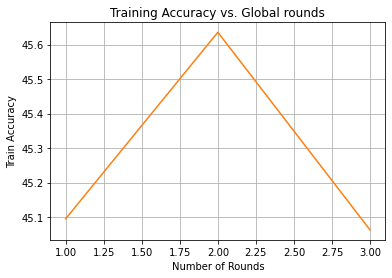

In [18]:
# number of training rounds
rounds = 3
# client fraction
C = 0.5
# number of clients
K = 10
# number of training passes on local dataset for each round
E = 3
# batch size
batch_size = 10
# learning Rate
lr=1e-05
# dict containing different type of data partition
data_dict = iid_partition(training_set, 10)
d={}

loss_function = torch.nn.CrossEntropyLoss()

if torch.cuda.is_available():
  model.cuda()

distilbert_iid_trained,train_acc = training(model, rounds, train_dataset, data_dict, loss_function, lr, C, K, E, "orange")

In [18]:
def calcuate_accuracy(big_idx, targets):
  n_correct = (big_idx==targets).sum().item()
  return n_correct

In [19]:
#Testing the trained model

def valid(model, testing_loader, loss_function):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            #token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask)
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accuracy(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    
    return epoch_accu


In [22]:
import pickle

print('This is the validation section to print the accuracy and see how it performs')
print('Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch')

acc = valid(distilbert_iid_trained, testing_loader, loss_function)
print("Accuracy on test data = %0.2f%%" % acc)

d['train_acc'] = train_acc
d['test_acc'] = acc


with open(f'/content/drive/My Drive/DistilBERT/DPFLDistilBERT_Dep_eps0_5.pkl', 'wb') as file:
  pickle.dump(d, file)

4it [00:00, 39.41it/s]

This is the validation section to print the accuracy and see how it performs
Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch
Validation Loss per 100 steps: 1.352217435836792
Validation Accuracy per 100 steps: 0.0


310it [00:05, 56.40it/s]

Validation Loss Epoch: 1.3371515404793524
Validation Accuracy Epoch: 49.4345718901454
Accuracy on test data = 49.43%


In [ ]:
# number of training rounds
rounds = 3
# client fraction
C = 0.5
# number of clients
K = 10
# number of training passes on local dataset for each round
E = 5
# batch size
batch_size = 10
# learning Rate
lr=1e-05
# dict containing different type of data partition
data_dict = non_iid_partition(training_set, 10, 240, 10, 10)
d={}
#iid_partition(training_set, 10)

loss_function = torch.nn.CrossEntropyLoss()
#model = 
if torch.cuda.is_available():
  model.cuda()

distilbert_non_iid_trained,train_acc = training(model, rounds, train_dataset, data_dict, loss_function, lr, C, K, E, "orange")

/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:523: UserWarning: A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
  "A ``sample_rate`` has been provided."
/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:195: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  "Secure RNG turned off. This is perfectly fine for experimentation as it allows "
0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full b

Training Loss per 5000 steps: 1.3566043376922607
Training Accuracy per 5000 steps: 62.5


310it [00:20, 14.80it/s]
2it [00:00, 15.11it/s]

The Total Accuracy for Epoch 1: 53.774727492935
Training Loss Epoch: 1.3352490717364895
Training Accuracy Epoch: 53.774727492935
Training Loss per 5000 steps: 1.3215125799179077
Training Accuracy per 5000 steps: 50.0


220it [00:15, 14.39it/s]

In [ ]:
import pickle
print('This is the validation section to print the accuracy and see how it performs')
print('Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch')

acc = valid(bert_non_iid_trained, testing_loader, loss_function)
print("Accuracy on test data = %0.2f%%" % acc)


d['train_acc'] = train_acc
d['test_acc'] = acc


with open(f'/content/drive/My Drive/DistilBERT/DPFLDistilBERT_Dep_eps0_5_noniid.pkl', 'wb') as file:
  pickle.dump(d, file)